This notebook contains the code that is used to calculate the Edgeworth coefficients for the Lorenz 63 system.

In [1]:
@everywhere using ODE
using PyPlot
using Covariances
using StatsBase
using JLD
using HDF5
using Distributions
using Interpolations
using LsqFit


"""
From Spectra.jl

	trapz{Tx<:Number, Ty<:Number}(x::Vector{Tx}, y::Vector{Ty})
Trapezoidal integration.
INPUTS:
	x: Vector{Float64} containing the x values;
	
	y: Vector{Float64} containing the y values.
OUTPUTS: 
	area: Vector{Float64}, the trapezoidal integration value.
This function is particularly helpful to calculate the area under a portion of a spectrum, and can be used for various purposes (normalisation, area comparison, etc.).
"""
function trapz{Tx<:Number, Ty<:Number}(x::Vector{Tx}, y::Vector{Ty})
    # Trapezoidal integration rule
    local n = length(x)
    if (length(y) != n)
        error("Vectors 'x', 'y' must be of same length")
    end
    r = zero(zero(Tx) + zero(Ty))
    if n == 1; return r; end
    for i in 2:n
        r += (x[i] - x[i-1]) * (y[i] + y[i-1])
    end
    trapz_int = r/2
    return trapz_int
end

function cumtrapz(x::Array{Float64,1},t::Array{Float64,1})
    meth(x1,x2,dt) = (1/2) * (x1 + x2) * dt
    as = [meth(x1,x2,t2-t1) for (x1,t1,x2,t2) in zip(x[1:end-1],t[1:end-1],x[2:end],t[2:end])]
    cumsum(as)
end

cumtrapz (generic function with 1 method)

In [11]:
@everywhere function L63(t,r;σ=10,ρ=28,β=8/3)
    return [σ*(r[2]-r[1]);
    r[1]*(ρ-r[3]) - r[2];
    r[1]*r[2] - β*r[3]]
end;

In [7]:
H₁(x) = x 
H₂(x) = x.^2 - 1 
H₃(x) = x.^3 - 3*x
H₄(x) = x.^4 - 6*x.^2 + 3
H₅(x) = x.^5 - 10*x.^3 + 15*x
H₆(x) = x.^6 - 15*x.^4 + 45*x.^2 - 15 
fₑ₂(x,c⁽¹⁾,σ,c₁⁽²⁾,c⁽³⁾,c⁽⁴⁾,ε) = 
pdf(Normal(0,σ),x).*(1 + √ε*((c⁽¹⁾/σ)*H₁(x/σ) + (c⁽³⁾/(6*σ^3))*H₃(x/σ))
    + ε*(((c₁⁽²⁾+c⁽¹⁾^2)/(2*σ^2))*H₂(x/σ) + ((c⁽⁴⁾+4*c⁽¹⁾*c⁽³⁾)/(24*σ^4))*H₄(x/σ) + (c⁽³⁾^2/(72*σ^6))*H₆(x/σ)))

fₑ₂ (generic function with 1 method)

### Generate initial conditions

In [164]:
# To speed up convergence to the Lorenz atrractor, initial conditions are generated
# by a small perturbations of positions on the unstable periodic orbits (UPOs) on the attractor.
# These UPOs have been provided by Prof. Divakar Viswanath (see Viswanath, Nonlinearity (2003))
# Otherwise initial conditions from a long transient run can be used.

# this function reads in UPO data for the Lorenz 63 system,


function readUPOs(UPODir)
    x = Array{Array{Float64,1}}(0)
    y = Array{Array{Float64,1}}(0)
    z = Array{Array{Float64,1}}(0)
    for orbitfile in filter(x -> startswith(x,"orbit") && endswith(x, "dat"), readdir((UPODir)))
        orbitstring = readlines(joinpath(UPODir,orbitfile));
        xᵢ = map(x->parse(Float64,x), split(orbitstring[1]));
        yᵢ = map(x->parse(Float64,x), split(orbitstring[2]));
        zᵢ = map(x->parse(Float64,x), split(orbitstring[3]));
        push!(x,xᵢ)
        push!(y,yᵢ)
        push!(z,zᵢ)
    end
    x, y , z
end
UPODir = "../data/l63-upos/"
xᵤ,yᵤ,zᵤ = UPOs.readUPOs(UPODir);

In [9]:
dt = 0.01;
Tᵢ₊ = 10
#Tᵢ₋ = 5
#iᵢ₊ = round(Int,Tᵢ₊/dt)
#iᵢ₋ = round(Int,Tᵢ₋/dt)
#jᵢ = iᵢ₋:50:iᵢ₊
tᵢ = 0:dt:Tᵢ₊;

In [412]:
# generate initial conditions
Mᵢ = 1000000
#yᵢ = SharedArray{Float64}(3,2*Mᵢ)
yᵢ = zeros(Mᵢ,3);

tic()
for i=1:Mᵢ
    i₀ = rand(1:length(xᵤ))
    j₀ = rand(1:length(xᵤ[i₀]))
    rᵢ = [xᵤ[i₀][j₀],yᵤ[i₀][j₀],zᵤ[i₀][j₀]] + 0.1*randn(3);
    (t₀, yᵢ₁)= ode45((t,r) -> L63(t,r), rᵢ, tᵢ, points=:specified);
    yᵢ[i,:] = yᵢ₁[end]
end
toc()

LoadError: [91mInterruptException:[39m

In [262]:
fname = "../../data/lorenz63-initial-conditions-"*string(now())*".jld"
save(fname, "yᵢ", convert(Array,yᵢ))

In [5]:
d = load("../../data/lorenz63-initial-conditions-2017-09-19T17:12:37.685.jld")
yᵢ = convert(Array,d["yᵢ"]);

### statistics of $f_0$

In [7]:
f₀ₛ =  "cos(y[2]/2)*(exp(y[1]/40))"
@everywhere eval(parse("f₀(y) = "*f₀ₛ))

In [566]:
Tₚ₊ = 10000
tₚ = 0:dt:Tₚ₊;

i₀ = rand(1:length(xᵤ))
j₀ = rand(1:length(xᵤ[i₀]))
rᵢ = [xᵤ[i₀][j₀],yᵤ[i₀][j₀],zᵤ[i₀][j₀]] + 0.1*randn(3);
(t₀, yᵢ₁)= ode45((t,r) -> L63(t,r), rᵢ, tₚ, points=:specified);
xᵢ = map(f₀,yᵢ₁);
xₓ = xcorr(xᵢ,xᵢ)[length(xᵢ):end];

i₀ = rand(1:length(xᵤ))
j₀ = rand(1:length(xᵤ[i₀]))
rᵢ = [xᵤ[i₀][j₀],yᵤ[i₀][j₀],zᵤ[i₀][j₀]] + 0.1*randn(3);
(t₀, yᵢ₁)= ode45((t,r) -> L63(t,r), rᵢ, tₚ, points=:specified);
xᵢ = map(f₀,yᵢ₁);
xₓ₂ = xcorr(xᵢ,xᵢ)[length(xᵢ):end];

#### calculate the mean of f₀

In [12]:
Tₘ₊ = 5
#Tₘ₊ = 1
tₘ = 0:dt:Tₘ₊;

Mₘ = 100000
#Mₘ = Mᵢ
μ₀ᵢ = zeros(Mₘ)
tic()
@sync @parallel for mᵢ = 1:Mₘ
    (t₀, yᵢ₁)= ode45((t,r) -> L63(t,r), vec(yᵢ[mᵢ,:]), tₘ, points=:specified);
    μ₀ᵢ[mᵢ] = trapz(vec(map(f₀, yᵢ₁)), t₀)/t₀[end]
end
μ₀ = mean(μ₀ᵢ)
toc()

elapsed time: 59.925065188 seconds


59.925065188

### Generate integrals of $f_0$

In [587]:
Tₑ₊ = 300
tₑ = 0:dt:Tₑ₊;

Mₑ = 100000
#Mₑ = 10000
R = 10
#R = 1
#Mₘ = Mᵢ
iₑ = 10:10:length(tₑ)
yₑ = SharedArray(zeros(Mₑ,length(iₑ)));
tic()
nowstr = Dates.format(now(), "dd-mm-yyyy-HH.MM.SS")
for r = 1:R
    @sync @parallel for mᵢ = 1:Mₑ
        (t₀, yᵢ₁)= ode45((t,r) -> L63(t,r), vec(yᵢ[mᵢ + (r-1)*Mₑ,:]), tₑ, points=:specified);
        yₑ[mᵢ,:] = cumtrapz(vec(map(f₀, yᵢ₁)) - μ₀, t₀)[iₑ]
    end
    fname = "../data/lorenz63-integrals-"*nowstr*"run"*string(r)*".jld"
    save(fname, "yₑ", convert(Array,yₑ), "tₑ", tₑ, "iₑ", iₑ, "μ₀", μ₀, "f₀ₛ", f₀ₛ)
end
toc()

elapsed time: 218.480491573 seconds


218.480491573

### Estimate Edgeworth coefficients

In [13]:
#loadstr = nowstr
#loadstr = "2017-09-20T15:41:10.147"
loadstr = "02-10-2017-07.25.31"
R = 10
R = 1

tₑ = load("../data/lorenz63-integrals-"*loadstr*"run1.jld", "tₑ")
iₑ = load("../data/lorenz63-integrals-"*loadstr*"run1.jld", "iₑ")
f₀ₛ = load("../data/lorenz63-integrals-"*loadstr*"run"*string(1)*".jld","f₀ₛ")
μ₀ = load("../data/lorenz63-integrals-"*loadstr*"run"*string(1)*".jld","μ₀")

μ₁ = zeros(R,length(iₑ))
μ₂ = zeros(R,length(iₑ))
μ₃ = zeros(R,length(iₑ))
μ₄ = zeros(R,length(iₑ))
for r=1:R
    yₑ = load("../data/lorenz63-integrals-"*loadstr*"run"*string(r)*".jld", "yₑ")
    μ₁[r,:] = vec(mean(yₑ,1))
    μ₂[r,:] = vec(var(yₑ,1))
    μ₃[r,:] = vec(mapslices(v->moment(v,3),yₑ,1))
    μ₄[r,:] = vec(mapslices(v->moment(v,4),yₑ,1))
end

LoadError: [91mFile ../data/lorenz63-integrals-02-10-2017-07.25.31run1.jld cannot be found[39m

In [99]:
model₁(t, p) = p[1].*t
fit₁ = curve_fit(model₁, tₑ[iₑ], vec(mean(μ₁,1)), [-0.0001])
μ₁₀ = fit₁.param[1]

0.00019155316203680914

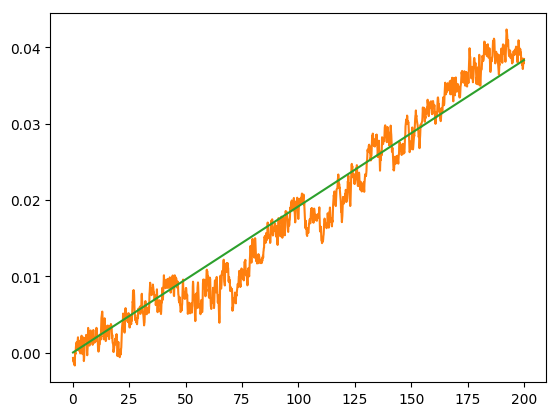

In [100]:
plot(tₑ[iₑ], vec(mean(μ₁,1)), color="C1")
plot(tₑ[iₑ], μ₁₀*tₑ[iₑ], color="C2");

In [101]:
model₂(t, p) = p[1] + p[2]./t
fit₂ = curve_fit(model₂, tₑ[iₑ][20:end], (vec(mean(μ₂,1))./tₑ[iₑ])[20:end], [0.002965, 0.005])
μ₂₀, μ₂₁ = fit₂.param

2-element Array{Float64,1}:
 0.00540008
 0.0334324 

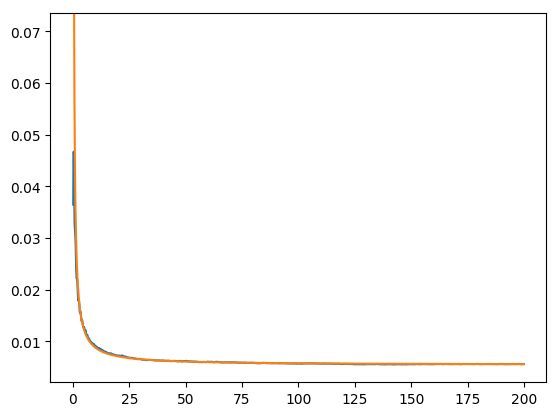

In [102]:
plot(tₑ[iₑ],vec(mean(μ₂,1))./tₑ[iₑ])

plot(tₑ, μ₂₀ + μ₂₁./tₑ)

ylim(sort([μ₂₀ - μ₂₁/10,μ₂₀ + μ₂₁/tₑ[iₑ[5]]]));

In [103]:
model₃(t, p) = p[1] + p[2]./t
j₃₀ = 65
j₃₁ = 750
fit₃ = curve_fit(model₃, tₑ[iₑ][j₃₀:j₃₁], (vec(mean(μ₃,1))./tₑ[iₑ])[j₃₀:j₃₁], [0.002965, 0.005])
μ₃₀, μ₃₁ = fit₃.param

2-element Array{Float64,1}:
 -0.00371567
 -0.0175834 

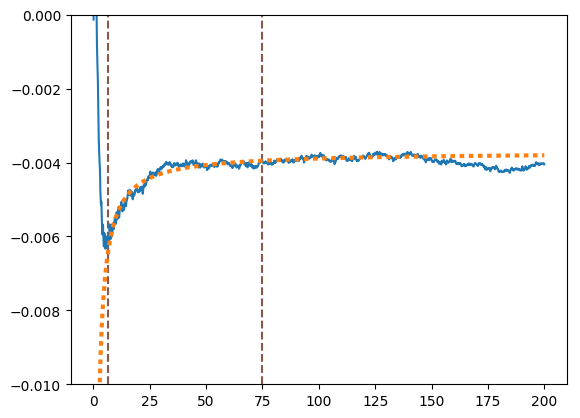

In [104]:
axvline(tₑ[iₑ[j₃₀]], ls="--", color="C5")
axvline(tₑ[iₑ[j₃₁]], ls="--", color="C5")

plot(tₑ[iₑ], vec(mean(μ₃,1))./tₑ[iₑ])

plot(tₑ, μ₃₀ + μ₃₁./tₑ, lw=3,ls=":")
ylim(-0.01,0.0);

In [105]:
model₄(t, p) = p[1] + p[2]./t
j₄₀ = 75
#j₄₁ = 800
j₄₁ = 750
fit₄ = curve_fit(model₄, tₑ[iₑ][j₄₀:j₄₁], (vec(mean(μ₄ - 3*μ₂.^2,1))./tₑ[iₑ])[j₄₀:j₄₁], [0.000014, 0.00024])
μ₄₀, μ₄₁ = fit₄.param

2-element Array{Float64,1}:
 0.00350628
 0.0425262 

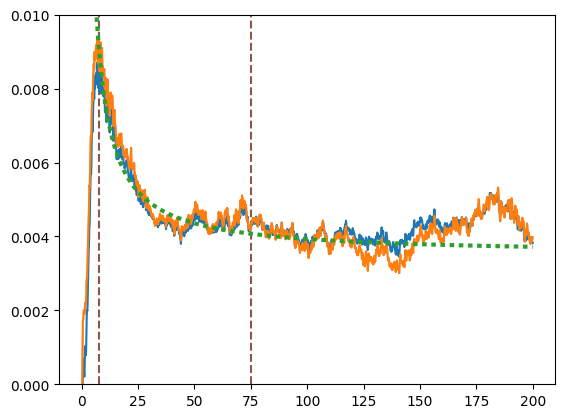

(0.0, 0.01)

In [106]:
for r=1:R
    #plot(tₑ[iₑ], (μ₄[r,:] - 3*μ₂[r,:].^2)./tₑ[iₑ], color="C3", alpha=0.3)
    plot(tₑ[iₑ], μ₄[r,:]./tₑ[iₑ]  - 3*μ₂₀.^2*tₑ[iₑ] - 6*μ₂₀*μ₂₁, color="C3", alpha=0.3)
end
axvline(tₑ[iₑ[j₄₀]], ls="--", color="C5")
axvline(tₑ[iₑ[j₄₁]], ls="--", color="C5")
plot(tₑ[iₑ], vec(mean(μ₄ - 3*μ₂.^2,1))./tₑ[iₑ])
plot(tₑ[iₑ], vec(mean(μ₄,1))./tₑ[iₑ] - 3*μ₂₀.^2*tₑ[iₑ] - 6*μ₂₀*μ₂₁)

plot(tₑ, μ₄₀ + μ₄₁./tₑ,lw=3,ls=":")
ylim(0.00,0.01)

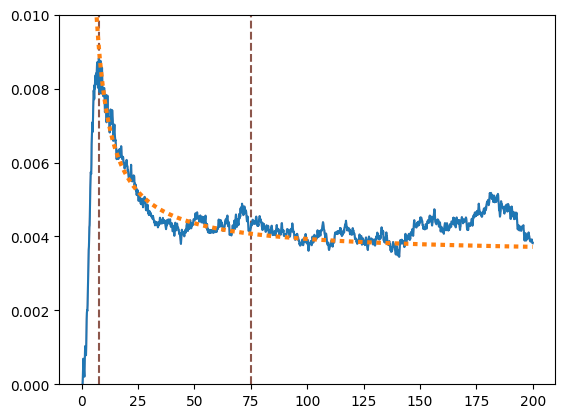

(0.0, 0.01)

In [107]:
for r=1:R
    plot(tₑ[iₑ], (μ₄[r,:] - 3*μ₂[r,:].^2)./tₑ[iₑ], color="C3", alpha=0.3)
end
axvline(tₑ[iₑ[j₄₀]], ls="--", color="C5")
axvline(tₑ[iₑ[j₄₁]], ls="--", color="C5")
plot(tₑ[iₑ], vec(mean(μ₄ - 3*μ₂.^2,1))./tₑ[iₑ])

plot(tₑ, μ₄₀ + μ₄₁./tₑ,lw=3,ls=":")

ylim(0.00,0.01)

In [108]:
h5open("edgeworth-coeff-"*Dates.format(now(), "dd-mm-yyyy-HH.MM.SS")*".h5", "w") do file
    write(file, "f₀ₛ", f₀ₛ, "μ₁", μ₀ - μ₁₀, "μ₂₀", μ₂₀, "μ₂₁", μ₂₁, "μ₃₀", μ₃₀, "μ₄₀", μ₄₀)
end